# ライブラリ

In [ ]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
iris = datasets.load_iris()
name = ["_".join(i.split(" ")[:2]) for i in iris.feature_names]

df = pd.DataFrame(iris.data, columns=name)
df['target'] = iris.target
df['target_label'] = iris.target_names[iris.target]

In [6]:
x = iris.data
y = iris.target

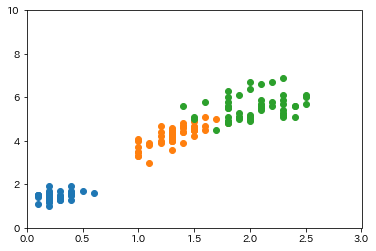

In [7]:
fig = plt.figure() 
ax = plt.axes()

for i in set(df["target"]):
    tmp = df[df["target"] ==i]
    ax.scatter(tmp["petal_width"],tmp["petal_length"])
    
ax.set_xlim([0,3])
ax.set_ylim([0,10])

plt.show()
    

In [8]:
def gini(y):
    _,counts = np.unique(y, return_counts=True)
    return 1 - np.sum((counts/np.sum(counts))**2)
    
    
def info_gain(y_1,y_2,y_3):
    parents_gini = gini(y_1)
    right_chi_gini = gini(y_2)
    left_chi_gini = gini(y_3)
    
    return parents_gini - len(y_2)/len(y_1)* right_chi_gini -len(y_3)/len(y_1)*left_chi_gini

def choose_node(x,y):
    best_feature,best_thread,best_ig= 0,0,0
    
    for feature in range(x.shape[1]):
        target_x = x[:,feature]
        indexer = target_x.argsort()

        _x = target_x[indexer]
        _y = y[indexer]

        arr = np.sort(np.unique(target_x))
        split_point = (arr[1:]+ arr[:-1])/2
        
        for sp in split_point:
            left = _y[_x < sp]
            right = _y[_x >= sp]
            
            ig = info_gain(_y,left,right)
            
            if ig > best_ig:
                best_feature,best_thread,best_ig = feature, sp, ig
                    
        
    return best_feature,best_thread,best_ig


In [9]:

class Tree_node:
    """
    ノードクラスの実装
    
    """
    def __init__(self, label, left=None, right=None):
        
        
        if label["terminal"]:
            self.label = None
            self.node = label["leaf"]
            self.thread_hold = None
            self.left = None
            self.right = None
            self.terminal = label["terminal"]
            self.depth = label["depth"] + 1
            
        else:
            self.label = label["feature"]
            self.label_name = name[label["feature"]]
            self.node = np.concatenate((label["left_y"], label["left_y"]), axis=0)
            self.thread_hold = np.round(label["thread"], 2)  # ノードの値を設定。
            self.left = left  #  左の枝につながるノードを設定。
            self.right = right  # 右の枝につながるノードを設定。
            self.terminal = label["terminal"]
            self.depth = label["depth"] + 1

    def __repr__(self, level=0):
        if level == 0:
            prefix = ""
        else:
            prefix = level*"   " + "└"
        
        s = "" if self.terminal else prefix +"IF " + "({})_".format(self.depth)+ "{}".format(self.label_name) + " > {}".format(self.thread_hold)
        if self.left:  
            s = s + "\n" + self.left.__repr__(level+1) 
        if self.right: 
            s = s + "\n" + self.right.__repr__(level+1) 
        return s  
    
    def _vote(self,data):
        if self.left is None and self.right is None:
            return np.argmax(np.bincount(self.node))
        elif self.thread_hold > data[self.label]:
            return self.left._vote(data)
        else:
            return self.right._vote(data)
                  
            
            
            
        

In [13]:
class Decision_tree():
    
    def __init__(self,max_depth = 3):
        
        self.max_depth = max_depth
        self.model = None
        
    def __repr__(self):
        if self.model is not None:
            return self.model.__repr__()
        
    def build_tree(self, x,y,depth = 0):  # 引数のリストから二分木を作成する関数。
    
       # ここでノードの分割を決める。
        feature, thread, ig = choose_node(x,y)

        #ここで木の成長がどこで止まるかを計算する
        if  depth == self.max_depth:
            return Tree_node(label={"leaf":y,
                           "terminal":True,
                            "depth":depth})
        # 閾値を下回ったら、左へ送る。
        left_x, left_y = x[x[:,feature] < thread], y[x[:,feature] < thread]
        right_x, right_y = x[x[:,feature] > thread], y[x[:,feature] > thread]

        return Tree_node(label={"feature":feature, 
                           "thread":thread, 
                           "left_y":left_y,
                           "right_y":right_y,
                           "terminal":False,
                          "depth":depth},
                    left=self.build_tree(left_x, left_y,depth = depth +1), 
                    right=self.build_tree(right_x, right_y ,depth= depth +1))  # i番目の要素を値に持つノードインスタンスを生成。

    def train(self, data,y):
        self.model = self.build_tree(data,y)
        
    
    def predict(self,data):
        result = []
        for d in data:
            result.append(self.model._vote(d))
        return np.array(result)


    

In [14]:
model = Decision_tree()

model.train(iris.data,iris.target)



In [15]:
model

IF (1)_petal_length > 2.45
   └IF (2)_sepal_length > 0
      └IF (3)_sepal_length > 0


      └IF (3)_sepal_length > 0


   └IF (2)_petal_width > 1.75
      └IF (3)_petal_length > 4.95


      └IF (3)_petal_length > 4.85


In [16]:
model.predict(x)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

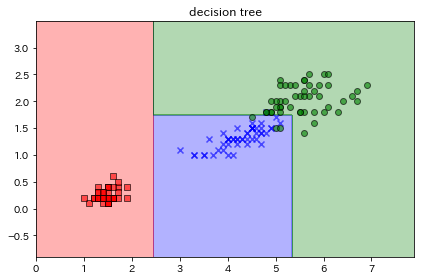

In [25]:
import numpy as np
from sklearn import datasets
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import math





data = datasets.load_iris()
x_data = data.data
y_data = data.target

# 2変数だけを抽出
# 
var_1 = 2
var_2 = 3

x_data = x_data[:, [var_1,var_2]]

# 入力データの各変数が平均0,標準偏差1になるように正規化
# 各アルゴリズムのプロット結果を比較しやすいように予め全入力データを正規化

# データを学習用/テスト用に分割している
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.2)

o
fig = plt.figure() 
ax = plt.axes() 

# モデルの学習

model = Decision_tree()

model.train(x_train, y_train)



resolution=0.01
## 今回は被説明変数が3クラスのため散布図のマーカータイプと3種類の色を用意
## クラスの種類数に応じて拡張していくのが良いでしょう
markers = ('s', 'x', 'o')
cmap = ListedColormap(('red', 'blue', 'green'))

## 2変数の入力データの最小値から最大値まで引数resolutionの幅でメッシュを描く
x1_min, x1_max = x[:, var_1].min()-1, x[:, var_1].max()+1
x2_min, x2_max = x[:, var_2].min()-1, x[:, var_2].max()+1
x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

## メッシュデータ全部を学習モデルで分類
z = model.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
z = z.reshape(x1_mesh.shape)

## メッシュデータと分離クラスを使って決定境界を描いている
plt.contourf(x1_mesh, x2_mesh, z, alpha=0.3, cmap=cmap)
plt.xlim(x1_mesh.min(), x1_mesh.max())
plt.ylim(x2_mesh.min(), x2_mesh.max())

for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=x[y == cl, var_1],
                y=x[y == cl, var_2],
                alpha=0.6,
                c=cmap(idx),
                edgecolors='black',
                marker=markers[idx],
                label=cl)
ax.set_title('decision tree')


plt.tight_layout()

plt.show()